In [1]:
from glob import glob
import os
from pathlib import Path
from denovo_utils.parsers.constants import EXTENSIONS
from pyteomics import mgf
from itertools import chain

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from psm_utils.io import read_file, write_file
from psm_utils import PSMList, PSM

from tqdm import tqdm

from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter

from denovo_utils.parsers.io import MGFWriter

from denovo_utils.parsers.constants import MODIFICATION_MAPPING_TO_SPECTRALIS

In [2]:
# Sage results
parser = DenovoEngineConverter.select("sage")
df = parser.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/F06.sage.tsv",
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F06.mgf"
).to_dataframe()

# XTandem results
parser_percolator = DenovoEngineConverter.select("percolator")
df1 = parser_percolator.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy/percolator/F06.pout",
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F06.mgf"
)
parser_percolator = DenovoEngineConverter.select("percolator")
df2 = parser_percolator.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator/percolator/F06.pout",
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F06.mgf"
)

In [3]:
df3 = (df1 + df2).to_dataframe()

def get_decoy_status(row):
    if row["source"] != "percolator":
        return None
    proteins = row["protein_list"]
    for protein in proteins:
        if "decoy" in protein:
            return True
    return False

df3["is_decoy"] = df3.apply(get_decoy_status, axis=1)

<Axes: xlabel='score', ylabel='Count'>

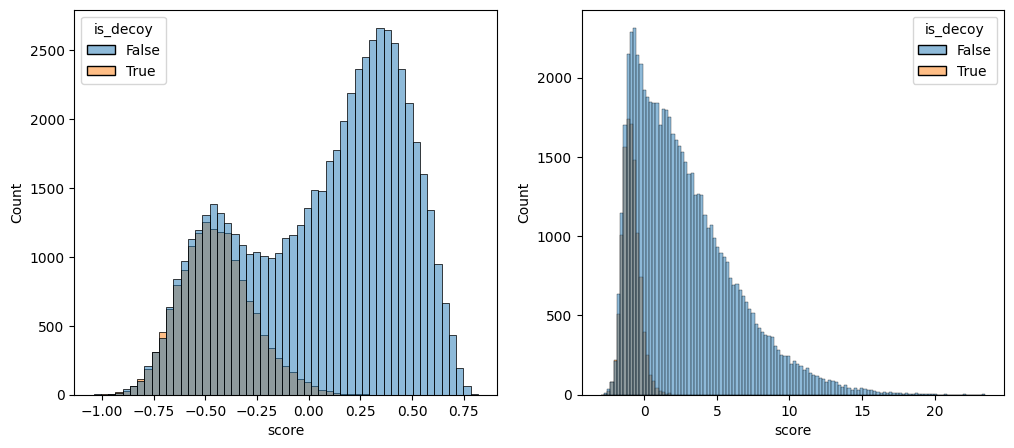

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(
    df,
    x="score",
    hue="is_decoy",
    ax=ax[0]
)
sns.histplot(
    df3,
    x="score",
    hue="is_decoy",
    ax=ax[1]
)

In [5]:
def get_psm_type(row, cutoff=.01):
    if row["is_decoy"]:
        return "decoy"
    elif row["qvalue"]<cutoff:
        return "target_accepted"
    return "target_rejected"
df["psm_type"] = df.apply(get_psm_type, axis=1)
df3["psm_type"] = df3.apply(get_psm_type, axis=1)

In [10]:
peptides_sage = df[df["psm_type"]=="target_accepted"]["peptidoform"].apply(lambda x: x.proforma.split("/")[0]).tolist()
peptides_xtandem = df3[df3["psm_type"]=="target_accepted"]["peptidoform"].apply(lambda x: x.proforma).tolist()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

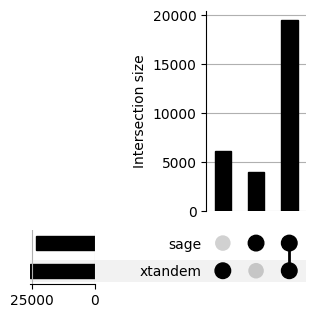

In [12]:
from upsetplot import from_contents, plot
data=from_contents(
    {
        "sage": set(peptides_sage),
        "xtandem": set(peptides_xtandem)
    }
)
plot(data)

In [26]:
df["psm_type"].value_counts()

target_accepted    40270
target_rejected    20497
decoy              15414
Name: psm_type, dtype: int64

In [27]:
df3["psm_type"].value_counts()

target_accepted    48888
target_rejected    15872
decoy              11042
Name: psm_type, dtype: int64

8600 less identifications when using sage, but it seems more stable

In [2]:
parser = DenovoEngineConverter.select("percolator")
df = parser.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator/percolator/S14_Rep1.pout",
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/S14_Rep1.mgf"
).to_dataframe()

<Axes: ylabel='Frequency'>

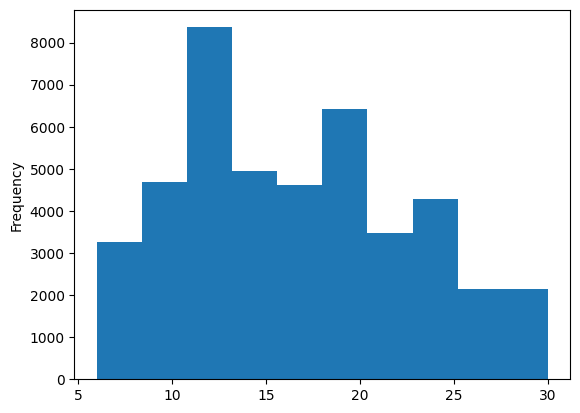

In [3]:
df.apply(lambda x: len(x["peptidoform"]), axis=1).plot(kind="hist")

---

# Parsing scripts

In [4]:
# Example of preprocessing spectralis input from a results file

writer = MGFWriter(
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F08_Rep2.mgf",
    modification_mapping=MODIFICATION_MAPPING_TO_SPECTRALIS,
    output_folder="./"
)

writer.read_result(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator/percolator/F08_Rep2.pout",
    denovo_engine="percolator"
)

writer.merge()

In [6]:
writer.write()

In [10]:
import re

# Checking for modification string patterns
pattern = r'\[([^\]]+)\]'

modifications = []

parser = DenovoEngineConverter.select("percolator")
for f in glob(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator/percolator/*.pout"
):
    mods = parser.parse(
        result_path=f,
        mgf_path=None
    ).to_dataframe().peptidoform.apply(lambda x: list(set(re.findall(pattern, x.proforma))))
    modifications.append(list(set(chain(*mods.tolist()))))
list(set(chain(*modifications)))

['UNIMOD:1', 'UNIMOD:35', 'UNIMOD:23', 'UNIMOD:4', 'UNIMOD:385']

['42.01057', '15.99492', '57.02147', '-18.01056', '-17.02655']

---

### 1. Check if parsing scripts work as expected

In [2]:
os.path.basename("/home/samva/Doctorate/data_directory/denovo_project/denovo_results")

'denovo_results'

In [3]:
root_result = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
root_mgf = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered"

def match_mgf_result(root_result, root_mgf):
    denovo = os.path.basename(root_result)

    mgf_result_dir = {}

    for path_mgf in glob(os.path.join(root_mgf, "*.mgf")):
        filename_mgf = os.path.basename(path_mgf).split(".")[0]
        for path_result in glob(os.path.join(root_result, f"*{EXTENSIONS[denovo]}")):
            filename_result = os.path.basename(path_result).split(".")[0]

            if filename_mgf == filename_result:
                mgf_result_dir[filename_mgf] = {
                    "mgf": path_mgf,
                    "result": path_result
                }
    return mgf_result_dir

def evaluate_parser(root_result, root_mgf, denovo):
    evaluation_metrics = {}
    mgf_result_dir = match_mgf_result(
        root_result=os.path.join(root_result, denovo),
        root_mgf=root_mgf
    )

    for filename, mgf_result in mgf_result_dir.items():
        parser = DenovoEngineConverter.select(denovo)
        psmlist = parser.parse(
            result_path=mgf_result["result"],
            mgf_path=mgf_result["mgf"]
        )
        evaluation_metrics[filename] = {
            "length_result": len(psmlist),
            "length_mgf": len(mgf.read(mgf_result["mgf"]))
        }
    return evaluation_metrics

In [4]:
metrics_pepnovo = evaluate_parser(
    root_result=root_result,
    root_mgf=root_mgf,
    denovo="pepnovo"
)

100%|██████████| 201050/201050 [00:03<00:00, 61974.05it/s]


In [ ]:
engines = [
    'casanovo',
    'contranovo',
    'instanovo',
    'novob',
    'pepnet',
    'novor',
    'pepnovo',
]

evaluation_metrics = {}
denovo_engine = ""
for denovo_engine in tqdm(engines, desc=f"Evaluated {denovo_engine}"):

    metrics = evaluate_parser(
        root_result=root_result,
        root_mgf=root_mgf,
        denovo=denovo_engine
    )
    evaluation_metrics[denovo_engine] = metrics

---

### 2.  Parse the spectralis output

In [2]:
spectralis_parser = SpectralisParser(
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf",
    results_dir="/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
)

In [3]:
spectralis_parser.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/denovo_results/refinement/spectralis/F01_Fraction1_annotated_rescoring.csv"
)

100%|██████████| 4531/4531 [00:00<00:00, 159878.11it/s]


In [4]:
spectralis_parser.added_results

{'Casanovo4.2.0': True, 'InstaNovo': True, 'PepNet': True, 'ContraNovo': True}

---

### Parsing percolator files and filenames

In [10]:
from glob import glob

# Renaming files
for filename in glob("/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy/*"):
    os.rename(filename, filename.replace("_searchengine_features", ""))

In [7]:
os.path.dirname(filename)

'/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy'

In [11]:
# Renaming files
for filename in glob("/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy/*"):
    filename_ext = os.path.basename(filename)
    file_dir = os.path.dirname(filename)
    os.rename(filename, os.path.join(file_dir, filename_ext.replace(".pout_dec", ".pout")))

In [12]:
# Splitting and renaming fractionated files

root="/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy"
target_dir = "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy"
split_files = [
    "F01_F1-4.pout",
    "F07_F1-4.pout",
    "S11_F1-4.pout"
]

for split_file in split_files:
    psmlist = read_file(
        filename=os.path.join(root, split_file),
        filetype="percolator"
    )

    psm_df = psmlist.to_dataframe()
    psm_df["filename"] = psm_df["spectrum_id"].apply(lambda x: "_".join(x.split("_")[:2]))
    psm_df["spectrum_id"] = psm_df["spectrum_id"].apply(lambda x: "_".join(x.split("_")[2:]))

    for f in psm_df.filename.unique():
        psm_selection = psm_df[psm_df.filename==f]
        psmlist_selection = PSMList(
            psm_list=[PSM(**x) for x in psm_selection.to_dict("records")]
        )
        print(f"Writing {f}...")
        write_file(
            psm_list=psmlist_selection,
            filename=os.path.join(target_dir, f+".pout"),
            filetype="percolator",
            style="pout"
        )

Writing F01_Fraction3...
Writing F01_Fraction2...
Writing F01_Fraction4...
Writing F01_Fraction1...
Writing F07_Fraction4...
Writing F07_Fraction3...
Writing F07_Fraction2...
Writing F07_Fraction1...
Writing S11_Fraction4...
Writing S11_Fraction2...
Writing S11_Fraction1...
Writing S11_Fraction3...


F08 and S14 files have an error in their reported spectrum_id. It misses a '+' character before MS2(...)

In [13]:
files_error = [
    "F08_Rep1",
    "F08_Rep2",
    "F08_Rep3",
    "S14_Rep1",
    "S14_Rep2",
    "S14_Rep3",
]

root_files = "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy/percolator"
destination = "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_decoy/fixed"

for filename in files_error:
    psmlist = read_file(
        os.path.join(root_files, filename + ".pout"),
        filetype="infer"
    )
    length_list=[]
    for psm in psmlist:
        psm["spectrum_id"] = psm["spectrum_id"].replace("  ", " +")
    write_file(
        psm_list=psmlist,
        filename=os.path.join(destination, filename+".pout"),
        filetype="percolator",
        style="pout",
        show_progressbar=True
    )

---

In [19]:
spectralis_out_processed.scans.nunique()

9157

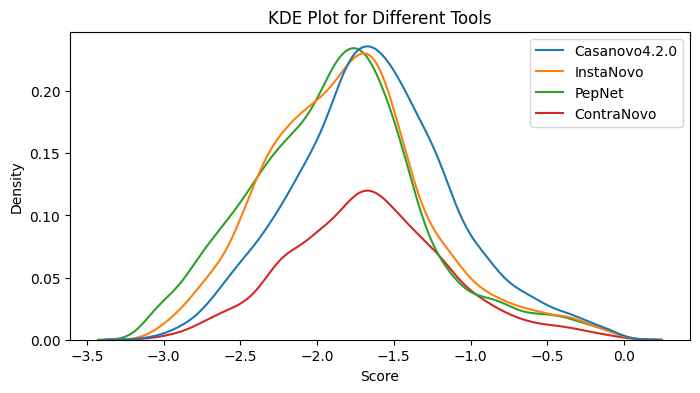

In [38]:
plt.figure(figsize=(8, 4))

scores = {}
for tool in ENGINES:
    scores[tool] = spectralis_out_processed['Spectralis_score'][spectralis_out_processed[tool]].tolist()

sns.kdeplot(
    scores, 
    common_norm=True
)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('KDE Plot for Different Tools')
plt.show()

In [32]:
spectralis_out_processed.sum(axis=0)

Spectralis_score                                        -53464.435289
scans               controllerType=0 controllerNumber=1 scan=4243c...
Casanovo4.2.0                                                    9045
InstaNovo                                                        8983
PepNet                                                           9157
ContraNovo                                                       4531
filename            F01_Fraction1F01_Fraction1F01_Fraction1F01_Fra...
dtype: object